<a href="https://colab.research.google.com/github/Ananda0047/Bangla-Sentiment-Analysis/blob/main/Bangla_Sent_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, Dropout,Flatten,Embedding
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D, Bidirectional, LSTM, GRU
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,Nadam,RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import pickle
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from tensorflow.keras.layers import Dropout,Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense,MaxPooling3D, GlobalMaxPooling3D, GlobalAveragePooling3D,Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D,BatchNormalization, Dropout, Flatten

### Dataset Loading

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Bangla_Sent.xlsx to Bangla_Sent.xlsx


In [4]:
import io
df_train = pd.read_excel(io.BytesIO(uploaded['Bangla_Sent.xlsx']))
# Dataset is now stored in a Pandas Dataframe

In [5]:
df_train.head()

,Text,Sentiment
0,অই জায়গার ডাক্তাররা কি গু খায় কে পাগল কে সুস্থ...,disgust
1,অনেকদিন হলো তাকে দেখিনা মাঝে মাঝে কান্না আসে,sadness
2,অগণতান্ত্রিক একটি জঘন্য দেশে আমার বাস,disgust
3,অটো রিস্কা বন্ধ করতে হবে তা না হলে আরো সংকট বে...,fear
4,অটোরিকশা বন্ধ না করলে আরও সংকট হবে মনে হচ্ছে,fear


In [6]:
df_train=df_train[["Text","Sentiment"]]

In [7]:
df_train.columns=["headlines","category"]

### Train Dataset Processing

In [8]:
df_train.head()

,headlines,category
0,অই জায়গার ডাক্তাররা কি গু খায় কে পাগল কে সুস্থ...,disgust
1,অনেকদিন হলো তাকে দেখিনা মাঝে মাঝে কান্না আসে,sadness
2,অগণতান্ত্রিক একটি জঘন্য দেশে আমার বাস,disgust
3,অটো রিস্কা বন্ধ করতে হবে তা না হলে আরো সংকট বে...,fear
4,অটোরিকশা বন্ধ না করলে আরও সংকট হবে মনে হচ্ছে,fear


In [9]:
df_train.describe()

,headlines,category
count,4819,4819
unique,4818,6
top,প্রশ্ন শুনে বুঝা যায় বাংলাদেশের অধিকাংশ সাংবাদ...,sadness
freq,2,827


<Axes: >

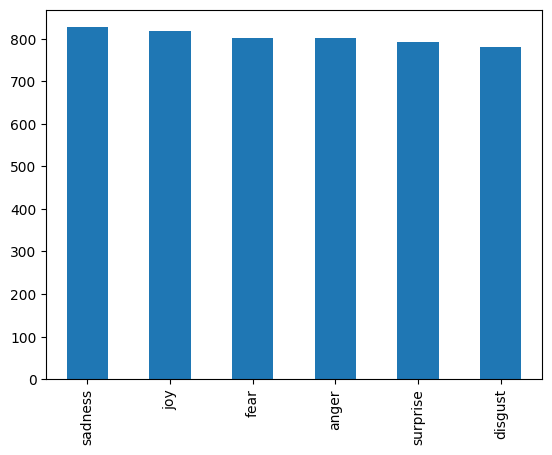

In [10]:
df_train["category"].value_counts().plot(kind="bar")

In [11]:
# sns.countplot(df_train.category)

In [12]:
df_train.isnull().sum()

headlines    0
category     0
dtype: int64

In [13]:
df_train = df_train.dropna()

In [14]:
df_train.category.value_counts()

sadness     827
joy         818
fear        802
anger       801
surprise    791
disgust     780
Name: category, dtype: int64

### Functions for preprocessing text

In [15]:
def remove_pattern(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text


punc = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰✌�￰৷￰'''
def remove_punc(text):
    cleaned = ""
    for char in text:
        if char not in punc:
            cleaned += char
    return cleaned

In [16]:
def preprocess(text):
    cleaned = remove_punc(remove_pattern(text))
    return cleaned

In [17]:
df_train['cleaned'] = df_train['headlines'].apply(preprocess)

In [18]:
df_train.head()

,headlines,category,cleaned
0,অই জায়গার ডাক্তাররা কি গু খায় কে পাগল কে সুস্থ...,disgust,অই জায়গার ডাক্তাররা কি গু খায় কে পাগল কে সুস্থ...
1,অনেকদিন হলো তাকে দেখিনা মাঝে মাঝে কান্না আসে,sadness,অনেকদিন হলো তাকে দেখিনা মাঝে মাঝে কান্না আসে
2,অগণতান্ত্রিক একটি জঘন্য দেশে আমার বাস,disgust,অগণতান্ত্রিক একটি জঘন্য দেশে আমার বাস
3,অটো রিস্কা বন্ধ করতে হবে তা না হলে আরো সংকট বে...,fear,অটো রিস্কা বন্ধ করতে হবে তা না হলে আরো সংকট বে...
4,অটোরিকশা বন্ধ না করলে আরও সংকট হবে মনে হচ্ছে,fear,অটোরিকশা বন্ধ না করলে আরও সংকট হবে মনে হচ্ছে


### Removing low length data

In [19]:
df_train['length'] = df_train['cleaned'].str.split().str.len()
df_train = df_train.loc[df_train['length']>=2]

In [20]:
# df_train=[""]

### Train Dataset summary

In [21]:
def show_summary(dataset):

    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category ==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Headlines:{}".format(len(list(dataset[dataset.category==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

documents,words,u_words,class_names = show_summary(df_train)


Class Name :  sadness
Number of Headlines:827
Number of Words:7619
Number of Unique Words:2256
Most Frequent Words:

কষ্ট	171
না	145
তার	142
আমার	122
আমি	111
সে	79
আমাকে	77
করে	74
দুঃখের	70
খারাপ	65

Class Name :  joy
Number of Headlines:818
Number of Words:6875
Number of Unique Words:1976
Most Frequent Words:

ধন্যবাদ	208
জন্য	119
আপনার	111
অনেক	99
ভাই	92
ভাল	84
আপনাদের	84
পুলিশ	83
এই	78
ভালো	71

Class Name :  fear
Number of Headlines:802
Number of Words:6101
Number of Unique Words:1354
Most Frequent Words:

ভয়	530
না	163
সে	150
তার	139
আমি	116
হয়	109
তাকে	109
তাই	105
আমার	94
হচ্ছে	92

Class Name :  anger
Number of Headlines:801
Number of Words:8132
Number of Unique Words:2573
Most Frequent Words:

রাগ	202
না	187
আমার	133
তার	124
সে	111
করে	110
এই	108
আমি	97
তাই	72
আর	68

Class Name :  surprise
Number of Headlines:791
Number of Words:7696
Number of Unique Words:1938
Most Frequent Words:

আমি	327
এই	185
আশ্চর্য	184
না	135
বিস্মিত	119
কি	109
একটি	108
এটা	91
এটি	82
সত্যিই	81

Class Name

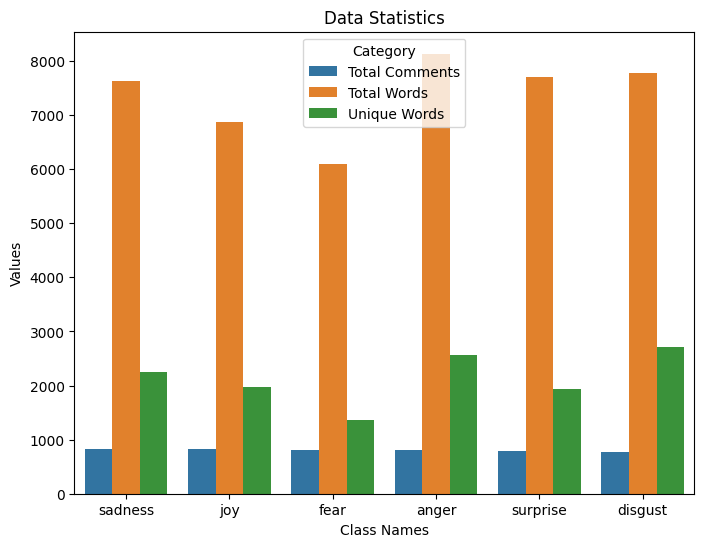

In [22]:
data_matrix = pd.DataFrame({'Total Comments':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names);

### Frequency length distribution

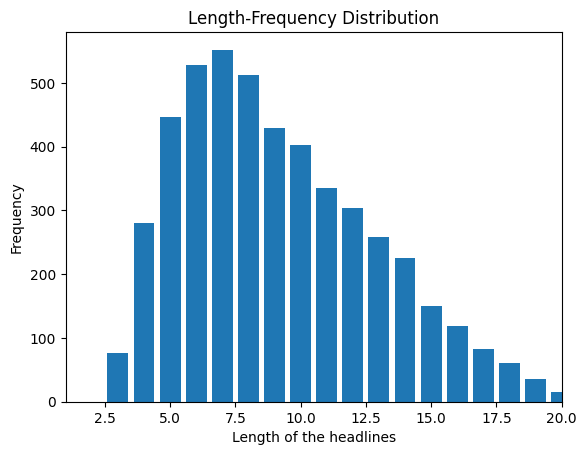

Maximum Length of a headlines: 21
Minimum Length of a headlines: 3
Average Length of a headlines: 9.0


In [23]:
frequency = dict()
for i in df_train.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values())
plt.xlim(1, 20)

plt.xlabel('Length of the headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a headlines: {max(df_train.length)}")
print(f"Minimum Length of a headlines: {min(df_train.length)}")
print(f"Average Length of a headlines: {round(np.mean(df_train.length),0)}")


### Tokenizing text

In [24]:
max_words = 50000
tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(df_train['cleaned'])

word_counts = tokenizer.word_counts
word_docs = tokenizer.word_docs
word_index = tokenizer.word_index
document_count = tokenizer.document_count

print(len(word_counts))

7737


In [25]:
with open('tokenizer_7th.pickle','wb') as f:
    pickle.dump(tokenizer,f,protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
X_tr,X_tt,y_tr,y_tt=train_test_split(df_train[["cleaned"]],df_train[["category"]],test_size=0.1,shuffle=True,stratify=df_train["category"],random_state=0)

In [27]:
# X_train

In [28]:
# df_train["cleaned"]

In [29]:
X_train_sequences = tokenizer.texts_to_sequences(X_tr.cleaned)
X_train_word_index = tokenizer.word_index

max_len = 100
X_train_corpus = pad_sequences(X_train_sequences, value=0, padding='post', maxlen= max_len)

In [30]:
X_test_sequences = tokenizer.texts_to_sequences(X_tt.cleaned)
X_test_word_index = tokenizer.word_index

max_len = 100
X_test_corpus = pad_sequences(X_test_sequences, value=0, padding='post', maxlen= max_len)

In [31]:
# for i in range(5):
#     print(f'Headline: {df_train.cleaned[i]} \n Sequence: {sequences[i]} \n padded sequence: \n {corpus[i]} \n')


In [32]:
y_train = y_tr['category']
X_train = X_train_corpus

y_test = y_tt['category']
X_test = X_test_corpus

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [34]:
# onehotencoder = OneHotEncoder()

In [35]:
# y_train = onehotencoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [36]:
# le = LabelEncoder()
# le.fit(y_train)
# y_train_enc = le.transform(y_train)

In [37]:
# y_train_enc

In [38]:
# encode textual labels into corresponding numbers
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
dummy_y_train = np_utils.to_categorical(encoded_y_train) # convert integer

encoded_y_test = encoder.transform(y_test)
dummy_y_test = np_utils.to_categorical(encoded_y_test) # convert integer

In [39]:
encoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [40]:
encoder.inverse_transform(encoded_y_train)

array(['surprise', 'joy', 'disgust', ..., 'sadness', 'joy', 'joy'],
      dtype=object)

In [41]:
dummy_y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

### Model Defination

In [42]:
embedding_dim = 128

#BiLSTM
bilstm_in = Input(shape=(max_len,))
bilstm_em_layer = Embedding(max_words,embedding_dim)(bilstm_in)
bilstm_layer_1 = Bidirectional(LSTM(32,dropout= 0.1))(bilstm_em_layer)
bilstm_dense_layer_1 = Dense(32,activation='relu')(bilstm_layer_1)
bilstm_flatten1 = Flatten()(bilstm_dense_layer_1)
bilstm_out = Dense(6,activation = 'softmax')(bilstm_flatten1)
bilstm_model = Model(inputs=bilstm_in, outputs=bilstm_out)

In [43]:
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          6400000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                             

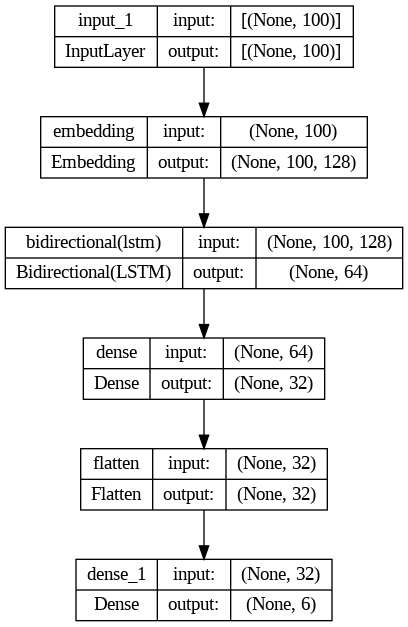

In [45]:
plot_model(bilstm_model, to_file='LF4_model.png', show_shapes=True, show_layer_names=True)

### Defining custom callbacks

In [46]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
early_stp = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=0,
    mode="auto",
)
model_check = ModelCheckpoint('LF_Trio_stp.h5', monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
callback_lst = [early_stp,model_check]

In [47]:
dummy_y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [48]:
# X_train.shape

In [49]:
bilstm_model

In [50]:
# history = bigru_model.fit(X_train,
#                           dummy_y_train,
#                           epochs = 30,
#                           batch_size = 64,
#                           verbose = 1,
#                           validation_split = 0.3,
#                           callbacks = callback_lst)

In [51]:
history = bilstm_model.fit(X_train,
                          dummy_y_train,
                          epochs = 30,
                          batch_size = 64,
                          verbose = 1,
                          validation_split = 0.1,
                          callbacks = callback_lst,
                       shuffle=True,)

Epoch 1/30
61/61 [==============================] - ETA: 0s - loss: 1.6896 - accuracy: 0.3413
Epoch 1: val_accuracy improved from -inf to 0.54378, saving model to LF_Trio_stp.h5
61/61 [==============================] - 24s 283ms/step - loss: 1.6896 - accuracy: 0.3413 - val_loss: 1.3936 - val_accuracy: 0.5438
Epoch 2/30
61/61 [==============================] - ETA: 0s - loss: 1.0254 - accuracy: 0.6879
Epoch 2: val_accuracy improved from 0.54378 to 0.67512, saving model to LF_Trio_stp.h5
61/61 [==============================] - 16s 267ms/step - loss: 1.0254 - accuracy: 0.6879 - val_loss: 0.8965 - val_accuracy: 0.6751
Epoch 3/30
61/61 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8978
Epoch 3: val_accuracy improved from 0.67512 to 0.79954, saving model to LF_Trio_stp.h5
61/61 [==============================] - 16s 260ms/step - loss: 0.4353 - accuracy: 0.8978 - val_loss: 0.6330 - val_accuracy: 0.7995
Epoch 4/30
61/61 [==============================] - ETA: 0s - lo

In [52]:
train_accr = bilstm_model.evaluate(X_train,dummy_y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(train_accr[0],train_accr[1]))

136/136 [==============================] - 5s 34ms/step - loss: 0.0937 - accuracy: 0.9786
Train set
  Loss: 0.094
  Accuracy: 0.979


In [53]:
test_accr = bilstm_model.evaluate(X_test,dummy_y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_accr[0],test_accr[1]))

16/16 [==============================] - 0s 23ms/step - loss: 0.8043 - accuracy: 0.8382
Test set
  Loss: 0.804
  Accuracy: 0.838


In [54]:
from sklearn.metrics import confusion_matrix

In [55]:
y_pred =bilstm_model.predict(X_test)

16/16 [==============================] - 1s 24ms/step


In [56]:
# y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(encoded_y_test, y_pred)

In [57]:

conf_mat

array([[64,  6,  4,  1,  2,  3],
       [ 8, 59,  0,  3,  5,  3],
       [ 2,  0, 73,  1,  3,  1],
       [ 2,  2,  1, 72,  3,  2],
       [ 0,  6,  5,  8, 63,  1],
       [ 2,  0,  0,  3,  1, 73]])

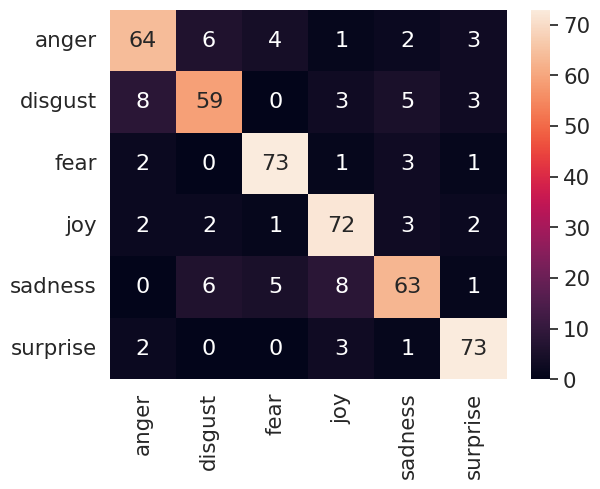

In [58]:
df_cm = pd.DataFrame(conf_mat, index=encoder.classes_, columns=encoder.classes_)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [59]:
from sklearn.metrics import classification_report
target_names = encoder.classes_
print(classification_report(encoded_y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.82      0.80      0.81        80
     disgust       0.81      0.76      0.78        78
        fear       0.88      0.91      0.90        80
         joy       0.82      0.88      0.85        82
     sadness       0.82      0.76      0.79        83
    surprise       0.88      0.92      0.90        79

    accuracy                           0.84       482
   macro avg       0.84      0.84      0.84       482
weighted avg       0.84      0.84      0.84       482



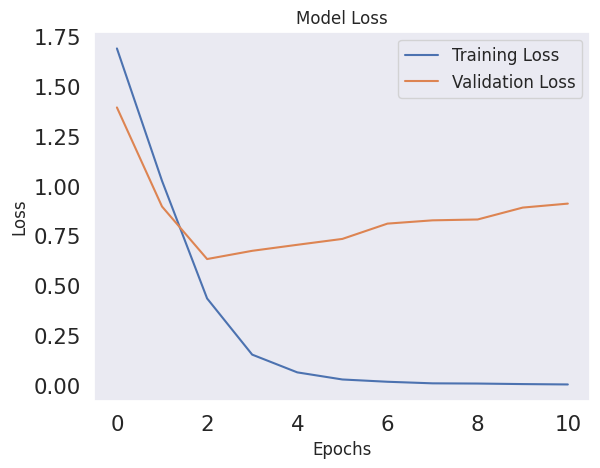

In [60]:
plt.title('Model Loss', fontsize=12)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(fontsize=12)
plt.grid(False)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.show();

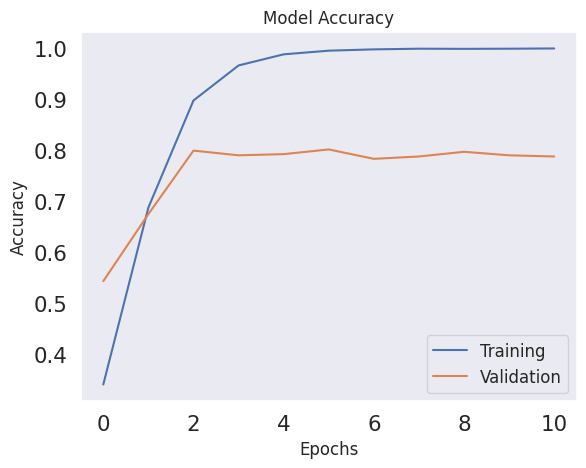

In [61]:
import matplotlib.pyplot as plt
plt.title('Model Accuracy', fontsize=12)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(fontsize=12)
plt.grid(False)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.show();

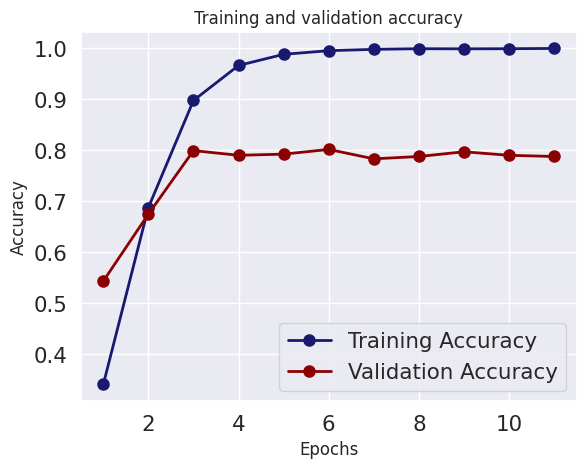

In [62]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color='midnightblue', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

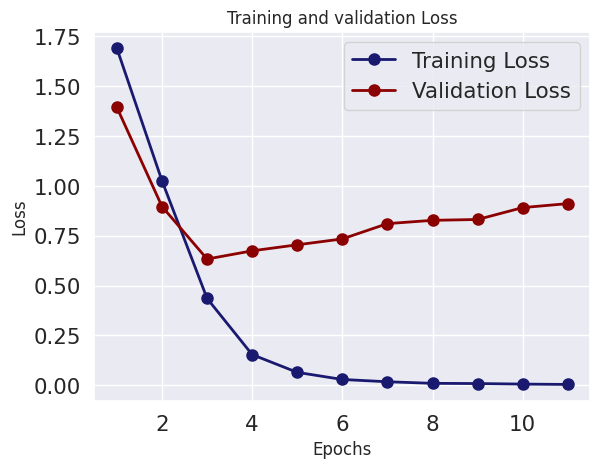

In [63]:
plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2,
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation Loss',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.legend(['Training Loss','Validation Loss'])

### Function for predicting Output

In [64]:
best_model = keras.models.load_model('./LF_Trio_stp.h5')
def predict_res(sample):
    processed_text = preprocess(sample)
    with open('./tokenizer_7th.pickle', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    seq= loaded_tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(seq, value=0,padding='post', maxlen= 100)
    pred = best_model.predict(padded)[0]
#     pred_f = (pred>0.5).astype('int')
    return pred

In [65]:
encoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [66]:
import operator
def sentiment(text):
    m=predict_res(text)
    index, value = max(enumerate(m), key=operator.itemgetter(1))
    return encoder.classes_[index]

In [67]:
sentiment('আমার ভয় করছে না জানে কি হয়')

1/1 [==============================] - 1s 889ms/step


'fear'

In [68]:
sentiment('তুমি পরীক্ষায় এত ভালো করবে ভাবিনি')

1/1 [==============================] - 0s 29ms/step


'joy'

In [69]:
sentiment('তুমি পরীক্ষায় এত ভালো করবে ভাবিনি')

1/1 [==============================] - 0s 31ms/step


'joy'

In [70]:
sentiment('আহা কি আনন্দ আকাশে বাতাসে')

1/1 [==============================] - 0s 34ms/step


'joy'